In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as func
import torchvision.transforms as transforms
from torch.autograd import Variable
from torchvision import models
from torch.utils.data import Dataset, DataLoader
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import confusion_matrix

In [3]:
# define the path of the trai  and test data
train_path = 'fashion-mnist_train.csv'
test_path = 'fashion-mnist_test.csv'

In [4]:
# load the dataset 
class fashion_mnist(Dataset):
    def __init__(self,path,transform=None):
        self.data = pd.read_csv(path)
        self.transform = transform
        img, label = [], []
        for i in self.data.values:
            img.append(i[1:])
            label.append(i[0])
        self.label = np.asarray(label)
        self.img = np.asarray(img).reshape(-1,28,28).astype('float32')
        
    def __getitem__(self,index):
        image, label = self.img[index], self.label[index]
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image,label
            
    def __len__(self):
        return len(self.img)
            
        return image, label

In [5]:
# load train and test data
transform = transforms.Compose([
   transforms.ToTensor() 
])

train_data = fashion_mnist(train_path,transform=transform)
test_data = fashion_mnist(test_path,transform=transform)

In [6]:
# define the hyperparameters and load the dataloader
batch_size = 60
#n_iters = 5000
learning_rate = 0.01
momentum = 0.3
#num_epochs = int(n_iters/(train_data.__len__()/batch_size))

# dataloader
train_loader = DataLoader(train_data,batch_size=batch_size,shuffle=True)
test_loader = DataLoader(test_data,batch_size=batch_size,shuffle =True)

In [7]:
# the tags in the datasets is given via a numbering system, below is the dict of the number and is corresponding tag
tags = {0 :'T-shirt/top',
                  1 :'Trouser',
                  2 :'Pullover',
                  3 :'Dress',
                  4 :'Coat',
                  5 :'Sandal',
                  6 :'Shirt',
                  7 :'Sneaker',
                  8 :'Bag',
                  9 :'Ankle boot'}

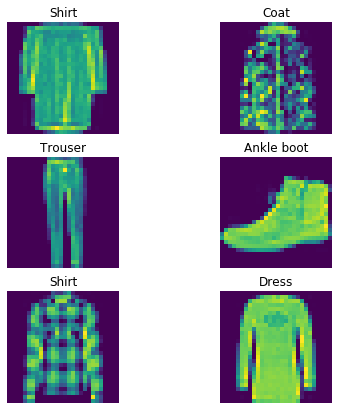

In [8]:
# iterate through the dataloader
_,(img,label) = next(enumerate(train_loader))
fig = plt.figure(figsize=(7,7))
for i in range(6):
    plt.subplot(3,2,i+1)
    plt.imshow(img[i][0])
    plt.axis('off')
    plt.title('{}'.format(tags[int(label[i].numpy())]))

In [79]:
# build the convolution neural network
class fashion_model(nn.Module):
    def __init__(self):
        super(fashion_model,self).__init__()
        
        # start with the bulind the model with convolution layers
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1,out_channels=16,kernel_size =5, stride=1,padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32,kernel_size=5,stride=1,padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2)
        )
        
        self.fc1 = nn.Linear(7*7*32,1000)
        self.fc2 = nn.Linear(1000,10)
        
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0),-1)
        out = nn.ReLU()(out)
        out = self.fc1(out)
        out = nn.ReLU()(out)
        out = self.fc2(out)
        return out

In [80]:
model = fashion_model()
error = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=learning_rate)

In [110]:
print(model)

fashion_model(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=1568, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=10, bias=True)
)


In [81]:
def train(num_epochs):
    
    model.train()
    correct = 0
    total = 0
    train_error=0

    for batch_id, (img,label) in enumerate(train_loader):
        img, label = Variable(img), Variable(label)
        optimizer.zero_grad()
        output = model(img)
        predict = torch.max(output.data,1)[1]
        correct += (predict==label).sum()
        total += len(label)
            
        # compute the loss
        loss = error(output, label)
        train_error = loss.item()
        loss.backward()
        optimizer.step()
            
        if (batch_id+1)%100 ==0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f} \t Accuracy: {}%'
                    .format(epoch,(batch_id+1)*len(label),len(train_loader.dataset),
                        100.0*(batch_id+1)/len(train_loader),loss.item(),100*correct/total))
                
            
    
    train_loss.append(train_error/int(len(train_loader)))
    train_acc.append(100*correct/total)
          
        
    # append the loss, accuracy and number of iterations
          

In [82]:
def test():
    model.eval()
    loss = 0
    correct = 0
    total = 0
    
    for i, (img,label) in enumerate(test_loader):
        img, label = Variable(img), Variable(label)
        
        output = model(img)
        predict = torch.max(output.data,1)[1]
        loss_error = error(output,label)
        loss += loss_error.item()
        total += len(label)
        correct += (predict==label).sum()
        
    loss /= len(test_loader.dataset)
    test_loss.append(loss)
    test_acc.append(100*correct/total)
    print('\nAverage Validation loss: {:.5f}\t Accuracy: {}'.format(loss,100*correct/total))

In [83]:
n_epochs = 10
train_loss = []
train_acc = []
test_loss = []
test_acc = []
for epoch in range(n_epochs):
    train(epoch)
    test()

Train Epoch: 0 [6000/60000 (10%)]	Loss: 0.678437 	 Accuracy: 63%
Train Epoch: 0 [12000/60000 (20%)]	Loss: 0.595381 	 Accuracy: 70%
Train Epoch: 0 [18000/60000 (30%)]	Loss: 0.502638 	 Accuracy: 74%
Train Epoch: 0 [24000/60000 (40%)]	Loss: 0.486310 	 Accuracy: 76%
Train Epoch: 0 [30000/60000 (50%)]	Loss: 0.349632 	 Accuracy: 78%
Train Epoch: 0 [36000/60000 (60%)]	Loss: 0.690727 	 Accuracy: 79%
Train Epoch: 0 [42000/60000 (70%)]	Loss: 0.458854 	 Accuracy: 80%
Train Epoch: 0 [48000/60000 (80%)]	Loss: 0.448559 	 Accuracy: 81%
Train Epoch: 0 [54000/60000 (90%)]	Loss: 0.463590 	 Accuracy: 81%
Train Epoch: 0 [60000/60000 (100%)]	Loss: 0.388342 	 Accuracy: 82%

Average Validation loss: 0.00608	 Accuracy: 86
Train Epoch: 1 [6000/60000 (10%)]	Loss: 0.511132 	 Accuracy: 88%
Train Epoch: 1 [12000/60000 (20%)]	Loss: 0.351023 	 Accuracy: 88%
Train Epoch: 1 [18000/60000 (30%)]	Loss: 0.325936 	 Accuracy: 88%
Train Epoch: 1 [24000/60000 (40%)]	Loss: 0.376291 	 Accuracy: 88%
Train Epoch: 1 [30000/60000 (

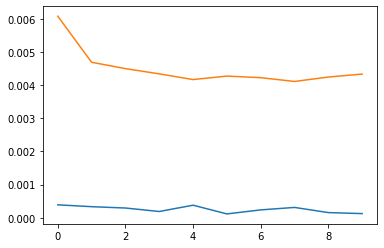

In [84]:
plt.plot(train_loss)
plt.plot(test_loss)

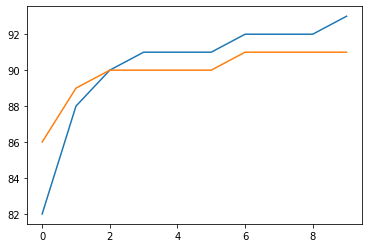

In [85]:
plt.plot(train_acc)
plt.plot(test_acc)

In [87]:
# save the model
torch.save(model.state_dict(),'fashion_mnist.pth')
torch.save(optimizer.state_dict,'optimizer.pth')

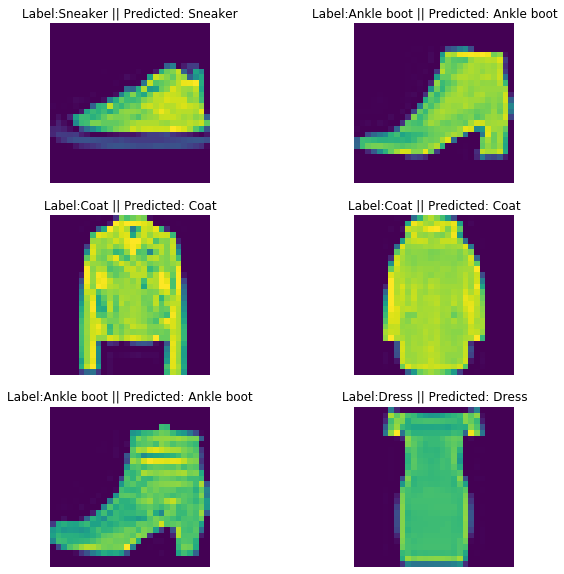

In [100]:
# load and predict from the model
_,(image,label) = next(enumerate(test_loader))
with torch.no_grad():
    output = model(image)
fig = plt.figure(figsize=(10,10))
for i in range(6):
    plt.subplot(3,2,i+1)
    plt.imshow(image[i][0])
    pred = output.data.max(1,keepdim=True)[1][i].item()
    plt.axis('off')
    plt.title('Label:{} || Predicted: {}'.format(tags[int(label[i].numpy())],tags[int(pred)]))